In [1]:
import pickle as pkl
import numpy as np
from tqdm import tqdm
from src.steinbrinker.BPDN import BPDN
import matplotlib.pyplot as plt
import pylops

In [2]:
VALID_INP_SIGS = 362
INP_SMPL_FREQ = 250

inp_sigs = np.load('data/steinbrinker/testing_data_mvg_avg.npy')[:, :VALID_INP_SIGS]
dictionary = np.load('data/steinbrinker/dictionary_BW_real_data.npy')
bw = np.load('data/generated/BW_noise.npy')

file_name = 'BW_master_10000_2024-04-07-12-43-32.pkl'
with open(f'data/generated/{file_name}', 'rb') as handle:
    gen_data = pkl.load(handle)

In [3]:
gen_data_size = gen_data['params']['GEN_DATA_SIZE']
inp_smpl_freq = gen_data['params']['INP_SMPL_FREQ']
gen_sig_secs = gen_data['params']['GEN_SIG_SECS']
valid_inp_sigs = gen_data['params']['VALID_INP_SIGS']
gen_sig_cuts = np.int_(gen_data['data'])
gen_sig_len = inp_smpl_freq * gen_sig_secs
lambda_param = 0.001
max_iters = 20

In [63]:
start_idx = 0
end_idx = 5

In [72]:
targets = np.zeros((end_idx - start_idx, dictionary.shape[0]))
noises = np.zeros((end_idx - start_idx, dictionary.shape[0]))
alphas_qp = np.zeros((end_idx - start_idx, dictionary.shape[1]))
alphas_fista = np.zeros((end_idx - start_idx, dictionary.shape[1]))
for i in tqdm(range(end_idx - start_idx)):
    targets[i, :] = inp_sigs[gen_sig_cuts[1, start_idx+i]:gen_sig_cuts[1, start_idx+i]+gen_sig_len, gen_sig_cuts[0, start_idx+i]]
    noises[i, :] = bw[gen_sig_cuts[2, start_idx+i]:gen_sig_cuts[2, start_idx+i]+gen_sig_len]
    alphas_qp[i, :] = BPDN(targets[i, :] + noises[i, :], dictionary, lambda_param=lambda_param, max_iters=max_iters)[1]

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:04<00:00, 12.85s/it]


In [81]:
def plot_est_comp(alphas, labels, targets, noises, dictionary, draw_idxs):
    fig, axs = plt.subplots(len(draw_idxs), 1, num=1, clear=True)
    fig.set_figheight(400*len(draw_idxs)/plt.rcParams['figure.dpi'])  
    fig.set_figwidth(1200/plt.rcParams['figure.dpi'])
    for ai, i in enumerate(draw_idxs):
        axs[ai].plot(targets[i, :] + noises[i, :],
                     label=f'INPUT (MSE: {np.sqrt(np.sum((noises[i, :])**2))})', linewidth=0.5)
        axs[ai].plot(targets[i, :],
                     label=f'TARGET', linewidth=0.5)
        for k in range(len(alphas)):
            denoised = targets[i, :] + noises[i, :] - dictionary@alphas[k][i, :]
            mse_loss = np.sqrt(np.sum((targets[i, :] - denoised)**2))
            axs[ai].plot(denoised,
                        label=f'{labels[k]} (MSE: {mse_loss})', linewidth=0.5)
        axs[ai].legend(prop={'size': 8})


def plot_alpha_comp(alphas, labels, draw_idxs):
    fig, axs = plt.subplots(len(draw_idxs), 1, num=1, clear=True)
    fig.set_figheight(400*len(draw_idxs)/plt.rcParams['figure.dpi'])
    fig.set_figwidth(1200/plt.rcParams['figure.dpi'])
    for ai, i in enumerate(draw_idxs):
        for k in range(len(alphas)):
            axs[ai].plot(np.linspace(0, 1, alphas[k][i, :].shape[0]), alphas[k][i, :], label=f'{labels[k]} (ZEROS: {np.sum(alphas[k][i, :]<1e-3)} / {alphas[k][i, :].shape[0]} | L1: {np.mean(np.abs(alphas[k][i, :]))})', linewidth=0.5)
        axs[ai].legend(prop={'size': 8})
        axs[ai].set_ylim(np.min(alphas[0][i, :]), np.max(alphas[0][i, :]))
    plt.show()

In [101]:
for i in tqdm(range(end_idx - start_idx)):
    alphas_fista[i, :], _, _ = pylops.optimization.sparsity.fista(
                                        pylops.MatrixMult(dictionary), target + noise,
                                        niter=100, eps=5e-1, tol=1e-3)

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 15.32it/s]


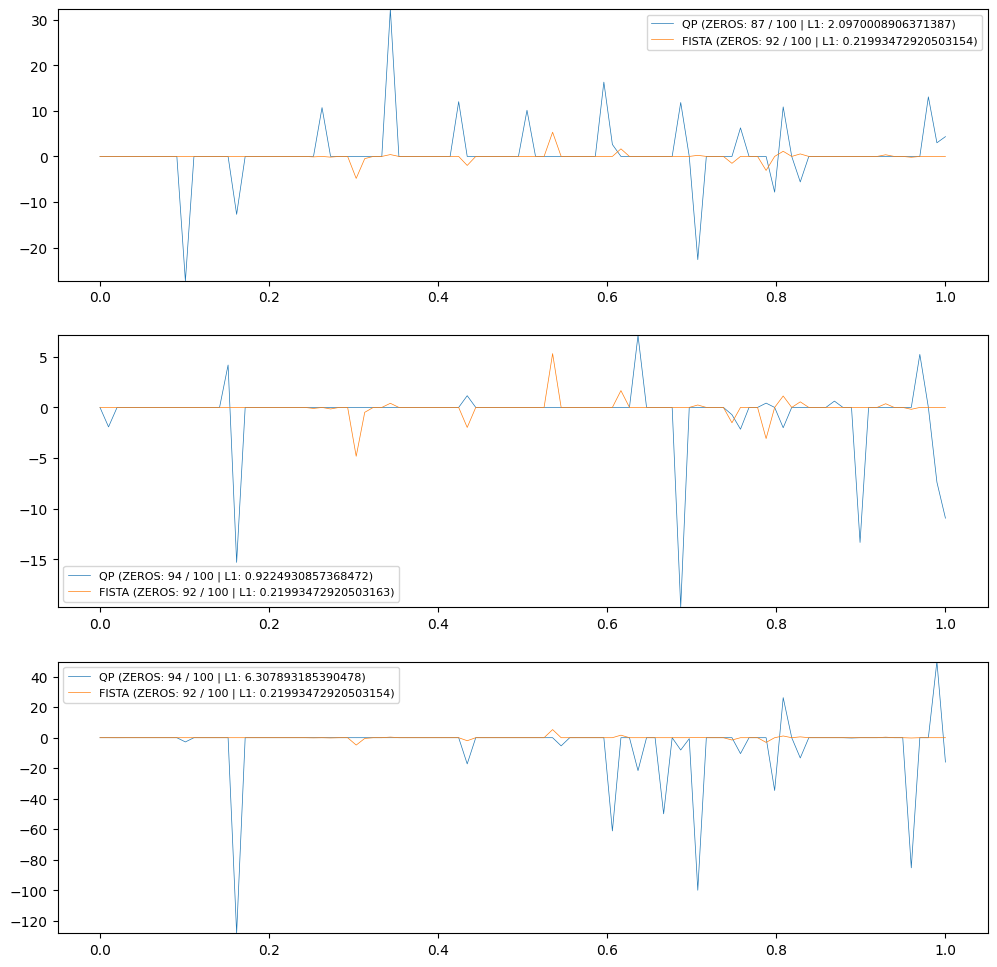

In [102]:
plot_alpha_comp([alphas_qp, alphas_fista], ['QP', 'FISTA'], list(range(3)))

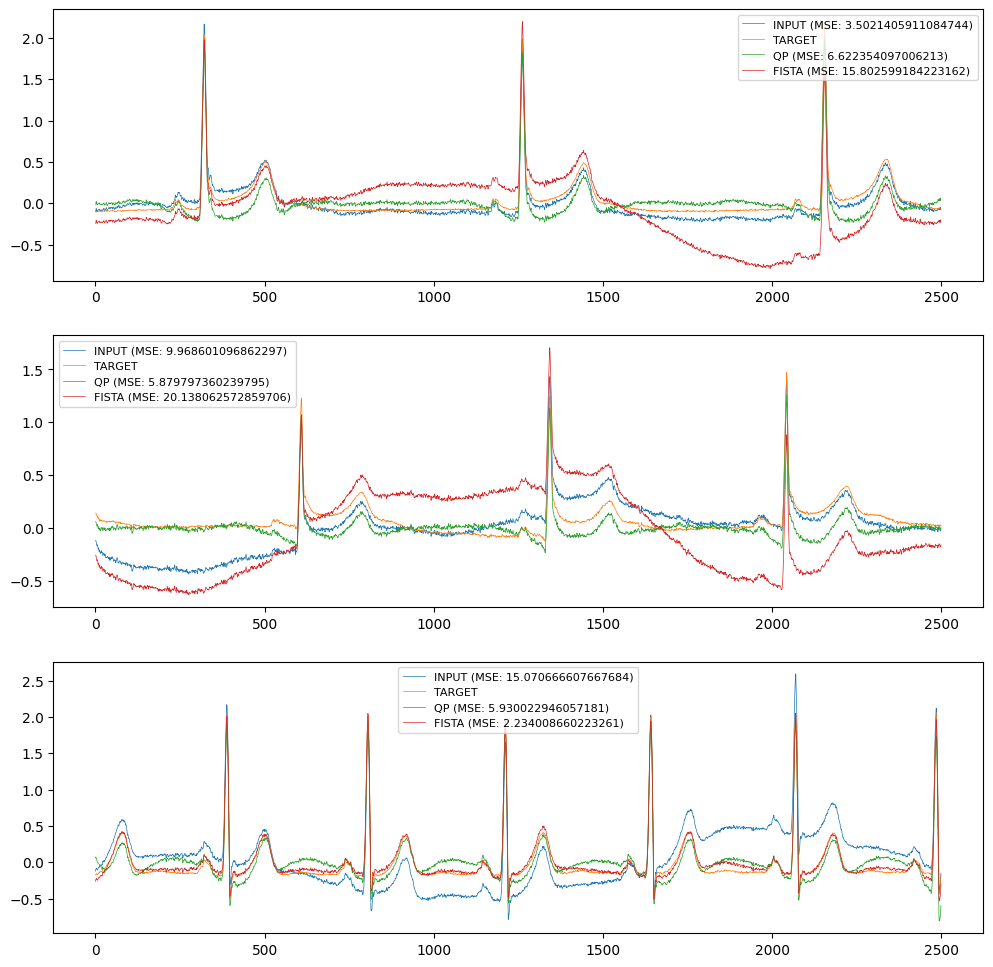

In [103]:
plot_est_comp([alphas_qp, alphas_fista], ['QP', 'FISTA'], targets, noises, dictionary, list(range(3)))

In [104]:
for i in tqdm(range(end_idx - start_idx)):
    alphas_fista[i, :], _, _ = pylops.optimization.sparsity.fista(
                                        pylops.MatrixMult(dictionary), target + noise,
                                        niter=100, eps=5e-10, tol=1e-3)

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 14.13it/s]


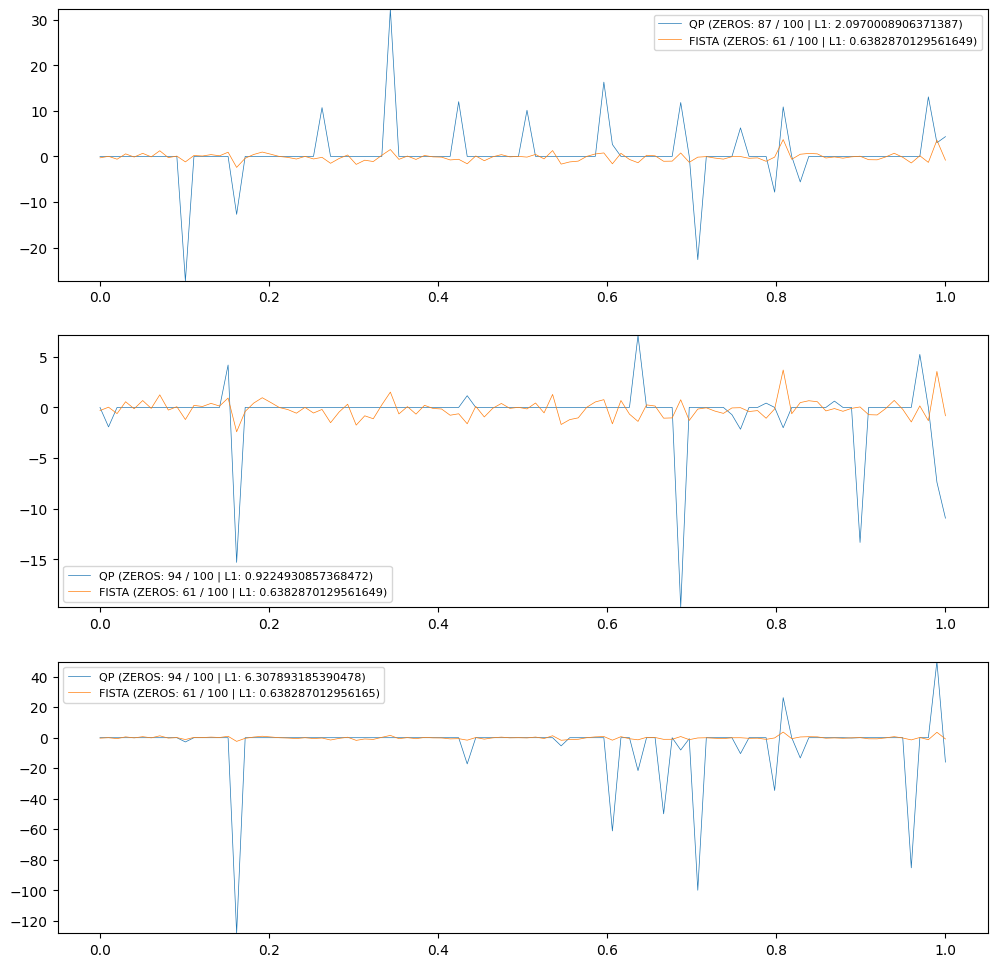

In [105]:
plot_alpha_comp([alphas_qp, alphas_fista], ['QP', 'FISTA'], list(range(3)))

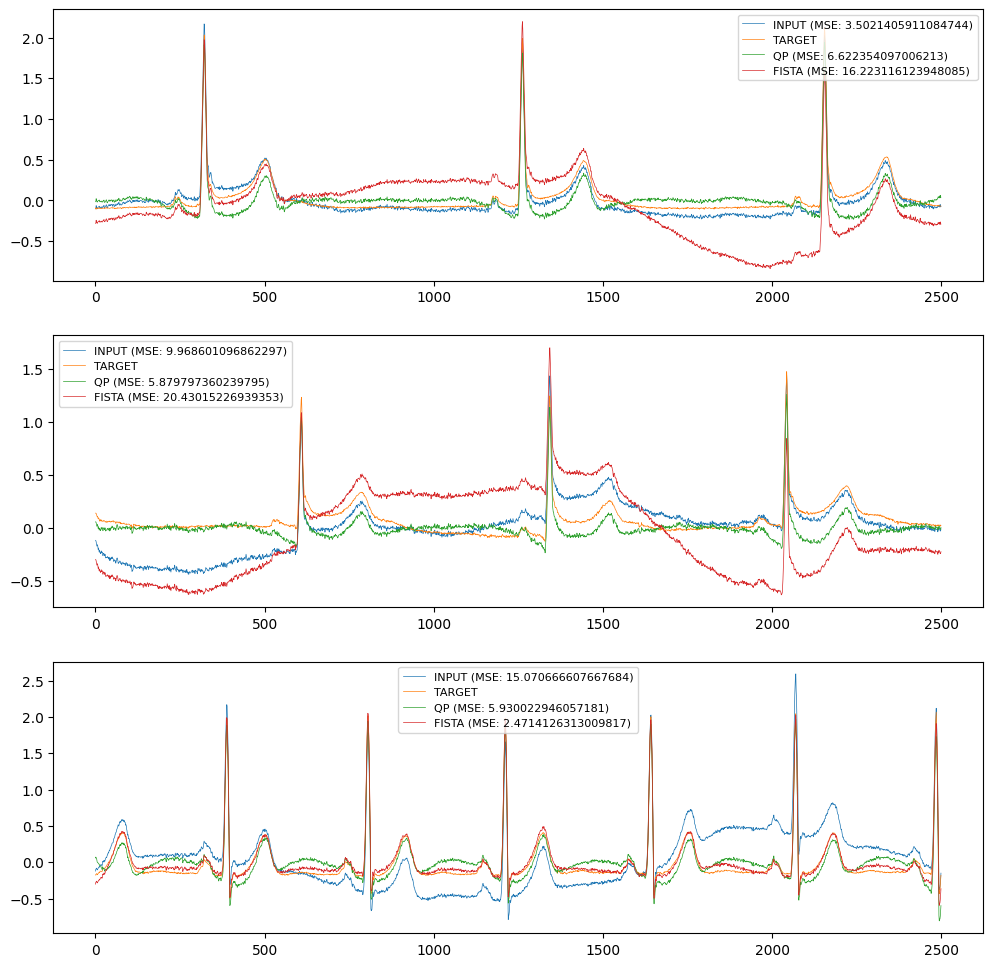

In [106]:
plot_est_comp([alphas_qp, alphas_fista], ['QP', 'FISTA'], targets, noises, dictionary, list(range(3)))